In [17]:
from pymongo  import MongoClient
import pandas as pd
import numpy as np
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn import decomposition, naive_bayes, preprocessing, model_selection, metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import model_selection
#! pip install scikit-surprise
from surprise import NormalPredictor, BaselineOnly, SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# Chargement des données AVIS

In [18]:
client = MongoClient(host="localhost", port=27017)
db = client["PLDAC_01"] 
collection = db["avis"]

In [19]:
df_avis = pd.DataFrame(list(collection.find())).loc[:,["author","title","note","date_published"]]
df_avis.head(5)

,author,title,note,date_published
0,Monsieur Guillaume,Mariposas,8.0,2021-01-27 11:06:44
1,morlockbob,Mariposas,7.0,2020-10-18 10:04:21
2,SwatSh,Mariposas,7.0,2021-02-01 08:35:08
3,Timi JeuxATheme,Mariposas,8.0,2020-11-19 17:04:57
4,prunelles,Mariposas,9.0,2021-05-24 12:43:18


In [20]:
num_utilisateurs  = df_avis["author"].nunique()
num_jeux  = df_avis["title"].nunique()

print(f"Il y a {num_users} utilisateurs et {num_jeux} jeux dans la base.")
print("Taile de la base:\n  ",len(df_avis))

Il y a 13623 utilisateurs et 10709 jeux dans la base.
Taile de la base:
   246524


## Stastistique sur les utilisateurs ayant noté plusieurs fois un jeu.

In [21]:
df_avis_unique = df_avis.groupby(['author','title']).value_counts()
df_avis_unique.head(10)

author            title                                note  date_published     
#yuyu#            Bubblee Pop                          8.5   2019-01-19 23:11:33    2
                  KARMAKA                              8.8   2018-02-25 09:01:19    2
$hadow            Le Dilemme du Roi                    9.0   2021-01-03 21:14:16    5
$lebat@$          Deluxe Camping                       10.0  2007-11-06 12:28:47    1
&lo               Sporz Original Outbreak              10.0  2011-01-18 12:28:59    1
*FitzChevalerie*  7 Wonders - Extension "Cities"       8.0   2012-11-20 13:36:22    1
                  7 Wonders - Extension "Wonder Pack"  7.4   2013-10-14 20:35:59    1
                  A Few Acres of Snow                  10.0  2012-05-23 12:29:05    1
                  Archipelago                          10.0  2012-10-16 13:36:22    1
                  Archipelago : Solo Expansion         10.0  2012-12-06 18:14:14    1
dtype: int64

Nous observons que se sont juste des diplications d'une même ligne.

## Suppression des duplications

In [22]:
df_avis = df_avis.drop_duplicates(subset=['author','title','note','date_published'])
df_avis.head()

,author,title,note,date_published
0,Monsieur Guillaume,Mariposas,8.0,2021-01-27 11:06:44
1,morlockbob,Mariposas,7.0,2020-10-18 10:04:21
2,SwatSh,Mariposas,7.0,2021-02-01 08:35:08
3,Timi JeuxATheme,Mariposas,8.0,2020-11-19 17:04:57
4,prunelles,Mariposas,9.0,2021-05-24 12:43:18


In [23]:
df_avis = df_avis[['author','title','note']]
num_utilisateurs  = df_avis["author"].nunique()
num_jeux  = df_avis["title"].nunique()

print(f"Il y a {num_utilisateurs} utilisateurs et {num_jeux} jeux dans la base après suppression des duplications.")
print("Nombre de lignes restantes dans la base:\n  ",len(df_avis))

Il y a 13623 utilisateurs et 10709 jeux dans la base après suppression des duplications.
Nombre de lignes restantes dans la base:
   176182


### 1. Statistique sur le nombre d'utilisateurs en fonction du nombre minimum de notes.

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

l_min = [0,5,10,20,30,50,100,200,300]
n_authors = []
n_titles = []
tailles_df = []

authors_counts = df_avis['author'].value_counts()
for min_note in l_min:
  authors = authors_counts[authors_counts >= min_note].index.to_list()
  n_authors.append(np.unique(authors).shape[0])
  
  df_avis_k = df_avis[df_avis['author'].isin(authors)]
  n_titles.append(df_avis_k["title"].nunique())
  tailles_df.append(len(df_avis_k))

print("Nombre minimums de notes requis:\n  ",l_min)
print("Liste du nombre d'authors restants:\n  ",n_authors)
print("Liste du nombre de jeux restants:\n  ",n_titles)
print("Taille de la base resultante:\n  ",tailles_df)

Nombre minimums de notes requis:
   [0, 5, 10, 20, 30, 50, 100, 200, 300]
Liste du nombre d'authors restants:
   [13623, 4701, 2849, 1631, 1176, 734, 359, 128, 61]
Liste du nombre de jeux restants:
   [10709, 10473, 10284, 9985, 9810, 9502, 8884, 7841, 6941]
Taille de la base resultante:
   [176182, 161268, 149070, 132486, 121520, 104609, 78628, 46249, 29916]


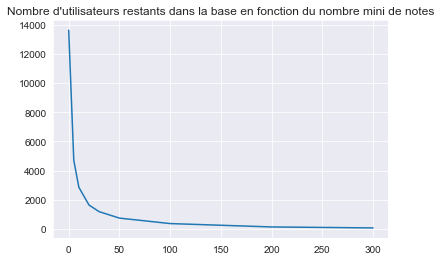

In [29]:
sns.set_style("darkgrid")
sns.lineplot(x=l_min,y=n_authors)
plt.title("Nombre d'utilisateurs restants dans la base en fonction du nombre mini de notes")
plt.show()

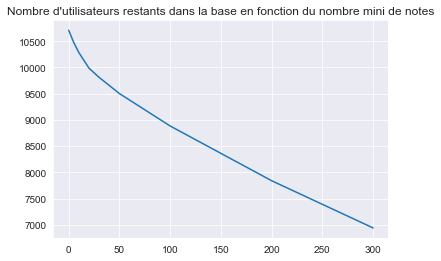

In [30]:
sns.set_style("darkgrid")
sns.lineplot(x=l_min,y=n_titles)
plt.title("Nombre d'utilisateurs restants dans la base en fonction du nombre mini de notes")
plt.show()

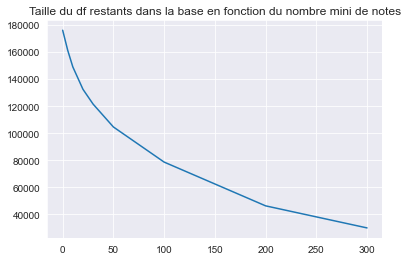

In [31]:
sns.set_style("darkgrid")
sns.lineplot(x=l_min,y=tailles_df)
plt.title("Taille du df restants dans la base en fonction du nombre mini de notes")
plt.show()

Nous avons decidé de prendre les trois cas suivants au vus des statisques après suppression de certains cas d'utilisateurs: 
- les utilisateurs ayant noté au moins 10 jeux
- les utilisateurs ayant noté au moins 100 jeux
- les utilisateurs ayant noté au moins 200 jeux
- les utilisateurs ayant noté au moins 300 jeux

## Déduction des quatres bases sur les quelles nous allons travailer et faire des comparaisons.

- df_avis_10 contient les données avec des utilisateurs ayant noté au moins 10 jeux
- df_avis_100 contient les données avec des utilisateurs ayant noté au moins 100 jeux
- df_avis_200 contient les données avec des utilisateurs ayant noté au moins 200 jeux
- df_avis_300 contient les données avec des utilisateurs ayant noté au moins 300 jeux

In [133]:
print(f"Taille de la base avant suppression:\n      --> {len(df_avis)}")

authors = df_avis['author'].value_counts()
authors_10  = authors[authors >= 10 ].index.to_list()
authors_100 = authors[authors >= 100].index.to_list()
authors_200 = authors[authors >= 200].index.to_list()
authors_300 = authors[authors >= 300].index.to_list()

df_avis_10  = df_avis[df_avis['author'].isin(authors_10)]
df_avis_100 = df_avis[df_avis['author'].isin(authors_100)]
df_avis_200 = df_avis[df_avis['author'].isin(authors_200)]
df_avis_300 = df_avis[df_avis['author'].isin(authors_300)]

print(f"Taille de la base après suppression des utilisateurs ayant noté moins de peu de jeux:")
print(f"  10  --> {len(df_avis_10)}")
print(f"  100 --> {len(df_avis_100)}")
print(f"  200 --> {len(df_avis_200)}")
print(f"  300 --> {len(df_avis_300)}")

Taille de la base avant suppression:
      --> 176182
Taille de la base après suppression des utilisateurs ayant noté moins de peu de jeux:
  10  --> 149070
  100 --> 78628
  200 --> 46249
  300 --> 29916


- La base df_avis_10  contient **149070** lignes pour **2849** utilisateurs et **10284** jeux.
- La base df_avis_100 contient **78628** lignes pour **359** utilisateurs et **8884** jeux.
- La base df_avis_200 contient **46249** lignes pour **128** utilisateurs et **7841** jeux.
- La base df_avis_300 contient **29916** lignes pour **61** utilisateurs et **6941** jeux.

## Separation des données en plusieurs données jouets pour la validation croisée(5 paquets de train/test).
Récupération de la liste de tous les jeux qui pourront être recommendés.

In [223]:

from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits,shuffle=True,random_state=0)

splits_10 = []
for train, test in kf.split(df_avis_10):
  X_train = df_avis_10.iloc[train].copy()
  X_test  = df_avis_10.iloc[test].copy()
  jeux_existants = set(X_train["title"].unique()) # ensemble des jeux existants
  jeux_counts = X_train.groupby('title')["note"].count().sort_values(ascending=False)
  jeux_populaires = jeux_counts.index.tolist()
  splits_10.append((X_train,X_test,(jeux_existants,jeux_populaires)))

splits_100 = []
for train, test in kf.split(df_avis_100):
  X_train = df_avis_100.iloc[train].copy()
  X_test  = df_avis_100.iloc[test].copy()
  jeux_existants = set(X_train["title"].unique()) # ensemble des jeux existants
  jeux_counts = X_train.groupby('title')["note"].count().sort_values(ascending=False)
  jeux_populaires = jeux_counts.index.tolist()
  splits_100.append((X_train,X_test,(jeux_existants,jeux_populaires)))

splits_200 = []
for train, test in kf.split(df_avis_200):
  X_train = df_avis_200.iloc[train].copy()
  X_test  = df_avis_200.iloc[test].copy()
  jeux_existants = set(X_train["title"].unique()) # ensemble des jeux existants
  jeux_counts = X_train.groupby('title')["note"].count().sort_values(ascending=False)
  jeux_populaires = jeux_counts.index.tolist()
  splits_200.append((X_train,X_test,(jeux_existants,jeux_populaires)))

splits_300 = []
for train, test in kf.split(df_avis_300):
  X_train = df_avis_300.iloc[train].copy()
  X_test  = df_avis_300.iloc[test].copy()
  jeux_existants = set(X_train["title"].unique()) # ensemble des jeux existants
  jeux_counts = X_train.groupby('title')["note"].count().sort_values(ascending=False)
  jeux_populaires = jeux_counts.index.tolist()
  splits_300.append((X_train,X_test,(jeux_existants,jeux_populaires)))

print(f"Validation croisée en {len(splits_10)} paquets")
    

Validation croisée en 5 paquets


## Nombre d'utilisateurs dans les paquets train et test

In [199]:
train_n_utils_10, train_n_jeux_10 = [],[]
train_n_utils_100, train_n_jeux_100 = [],[]
train_n_utils_200, train_n_jeux_200 = [],[]
train_n_utils_300, train_n_jeux_300 = [],[]

test_n_utils_10, test_n_jeux_10 = [],[]
test_n_utils_100, test_n_jeux_100 = [],[]
test_n_utils_200, test_n_jeux_200 = [],[]
test_n_utils_300, test_n_jeux_300 = [],[]

for ip in range(n_splits):
  X_train_10,X_test_10,je   = splits_10[ip]
  train_n_utils_10.append(X_train_10['author'].nunique())
  test_n_utils_10.append(X_test_10['author'].nunique())
  train_n_jeux_10.append(X_train_10['title'].nunique())
  test_n_jeux_10.append(X_test_10['title'].nunique())

  X_train_100,X_test_100,je = splits_100[ip]
  train_n_utils_100.append(X_train_100['author'].nunique())
  test_n_utils_100.append(X_test_100['author'].nunique())
  train_n_jeux_100.append(X_train_100['title'].nunique())
  test_n_jeux_100.append(X_test_100['title'].nunique())
  
  X_train_200,X_test_200,je = splits_200[ip]
  train_n_utils_200.append(X_train_200['author'].nunique())
  test_n_utils_200.append(X_test_200['author'].nunique())
  train_n_jeux_200.append(X_train_200['title'].nunique())
  test_n_jeux_200.append(X_test_200['title'].nunique())
  
  X_train_300,X_test_300,je = splits_300[ip]
  train_n_utils_300.append(X_train_300['author'].nunique())
  test_n_utils_300.append(X_test_300['author'].nunique())
  train_n_jeux_300.append(X_train_300['title'].nunique())
  test_n_jeux_300.append(X_test_300['title'].nunique())

In [200]:
print("Avec les utilisateurs ayant noté au moins 10 jeux:")
print("  Utilisateurs:")
print(f"\tNombre d'utilisateurs dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_utils_10)} std: {np.std(train_n_utils_10)}\n\t\t --> {train_n_utils_10}")
print(f"\tNombre d'utilisateurs dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_utils_10)} std: {np.std(test_n_utils_10)}\n\t\t --> {test_n_utils_10}")
print("  Jeux:")
print(f"\tNombre de jeux dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_jeux_10)} std: {np.std(train_n_jeux_10)}\n\t\t --> {train_n_jeux_10}")
print(f"\tNombre de jeux dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_jeux_10)} std: {np.std(test_n_jeux_10)}\n\t\t --> {test_n_jeux_10}")

Avec les utilisateurs ayant noté au moins 10 jeux:
  Utilisateurs:
	Nombre d'utilisateurs dans l'ensemble d'apprentissage:
		moy: 2849.0 std: 0.0
		 --> [2849, 2849, 2849, 2849, 2849]
	Nombre d'utilisateurs dans l'ensemble de test:
		moy: 2774.2 std: 5.635601121442148
		 --> [2769, 2782, 2780, 2769, 2771]
  Jeux:
	Nombre de jeux dans l'ensemble d'apprentissage:
		moy: 9680.0 std: 20.48414020651099
		 --> [9678, 9701, 9648, 9703, 9670]
	Nombre de jeux dans l'ensemble de test:
		moy: 6070.6 std: 14.66424222385869
		 --> [6079, 6065, 6095, 6055, 6059]


In [201]:
print("Avec les utilisateurs ayant noté au moins 100 jeux:")
print("  Utilisateurs:")
print(f"\tNombre d'utilisateurs dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_utils_100)} std: {np.std(train_n_utils_100)}\n\t\t --> {train_n_utils_100}")
print(f"\tNombre d'utilisateurs dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_utils_100)} std: {np.std(test_n_utils_100)}\n\t\t --> {test_n_utils_100}")
print("  Jeux:")
print(f"\tNombre de jeux dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_jeux_100)} std: {np.std(train_n_jeux_100)}\n\t\t --> {train_n_jeux_100}")
print(f"\tNombre de jeux dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_jeux_100)} std: {np.std(test_n_jeux_100)}\n\t\t --> {test_n_jeux_100}")

Avec les utilisateurs ayant noté au moins 100 jeux:
  Utilisateurs:
	Nombre d'utilisateurs dans l'ensemble d'apprentissage:
		moy: 359.0 std: 0.0
		 --> [359, 359, 359, 359, 359]
	Nombre d'utilisateurs dans l'ensemble de test:
		moy: 359.0 std: 0.0
		 --> [359, 359, 359, 359, 359]
  Jeux:
	Nombre de jeux dans l'ensemble d'apprentissage:
		moy: 8265.6 std: 40.60837352074077
		 --> [8269, 8236, 8280, 8212, 8331]
	Nombre de jeux dans l'ensemble de test:
		moy: 4749.4 std: 40.96144528700129
		 --> [4783, 4789, 4716, 4773, 4686]


In [202]:
print("Avec les utilisateurs ayant noté au moins 200 jeux:")
print("  Utilisateurs:")
print(f"\tNombre d'utilisateurs dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_utils_200)} std: {np.std(train_n_utils_200)}\n\t\t --> {train_n_utils_200}")
print(f"\tNombre d'utilisateurs dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_utils_200)} std: {np.std(test_n_utils_200)}\n\t\t --> {test_n_utils_200}")
print("  Jeux:")
print(f"\tNombre de jeux dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_jeux_200)} std: {np.std(train_n_jeux_200)}\n\t\t --> {train_n_jeux_200}")
print(f"\tNombre de jeux dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_jeux_200)} std: {np.std(test_n_jeux_200)}\n\t\t --> {test_n_jeux_200}")

Avec les utilisateurs ayant noté au moins 200 jeux:
  Utilisateurs:
	Nombre d'utilisateurs dans l'ensemble d'apprentissage:
		moy: 128.0 std: 0.0
		 --> [128, 128, 128, 128, 128]
	Nombre d'utilisateurs dans l'ensemble de test:
		moy: 128.0 std: 0.0
		 --> [128, 128, 128, 128, 128]
  Jeux:
	Nombre de jeux dans l'ensemble d'apprentissage:
		moy: 7226.4 std: 6.6211781428987395
		 --> [7218, 7220, 7236, 7228, 7230]
	Nombre de jeux dans l'ensemble de test:
		moy: 3856.4 std: 25.695135726436625
		 --> [3810, 3884, 3852, 3861, 3875]


In [203]:
print("Avec les utilisateurs ayant noté au moins 300 jeux:")
print("  Utilisateurs:")
print(f"\tNombre d'utilisateurs dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_utils_300)} std: {np.std(train_n_utils_300)}\n\t\t --> {train_n_utils_300}")
print(f"\tNombre d'utilisateurs dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_utils_300)} std: {np.std(test_n_utils_300)}\n\t\t --> {test_n_utils_300}")
print("  Jeux:")
print(f"\tNombre de jeux dans l'ensemble d'apprentissage:\n\t\tmoy: {np.mean(train_n_jeux_300)} std: {np.std(train_n_jeux_300)}\n\t\t --> {train_n_jeux_300}")
print(f"\tNombre de jeux dans l'ensemble de test:\n\t\tmoy: {np.mean(test_n_jeux_300)} std: {np.std(test_n_jeux_300)}\n\t\t --> {test_n_jeux_300}")

Avec les utilisateurs ayant noté au moins 300 jeux:
  Utilisateurs:
	Nombre d'utilisateurs dans l'ensemble d'apprentissage:
		moy: 61.0 std: 0.0
		 --> [61, 61, 61, 61, 61]
	Nombre d'utilisateurs dans l'ensemble de test:
		moy: 61.0 std: 0.0
		 --> [61, 61, 61, 61, 61]
  Jeux:
	Nombre de jeux dans l'ensemble d'apprentissage:
		moy: 6356.6 std: 10.09158064923429
		 --> [6357, 6340, 6371, 6361, 6354]
	Nombre de jeux dans l'ensemble de test:
		moy: 3175.0 std: 14.042791745233567
		 --> [3195, 3151, 3175, 3176, 3178]


Cas où les utilisateurs ont noté plus de 10 jeux.
- Nombre d'utilisateurs dans l'ensemble de la base: **2849**
- Nombre d'utilisateurs dans l'ensemble d'apprentissage en moyenne: **2842.8**</br>
- Nombre d'utilisateurs dans l'ensemble de test en moyenne: **2385.2**

Cas où les utilisateurs ont noté plus de 100 jeux.
- Nombre d'utilisateurs dans l'ensemble de la base: **359**
- Nombre d'utilisateurs dans l'ensemble d'apprentissage en moyenne: **359.0**</br>
- Nombre d'utilisateurs dans l'ensemble de test en moyenne: **358.0**

Cas où les utilisateurs ont noté plus de 200 jeux.
- Nombre d'utilisateurs dans l'ensemble de la base: **128**
- Nombre d'utilisateurs dans l'ensemble d'apprentissage en moyenne: **128.0**</br>
- Nombre d'utilisateurs dans l'ensemble de test en moyenne: **128.0**

Cas où les utilisateurs ont noté plus de 300 jeux.
- Nombre d'utilisateurs dans l'ensemble de la base: **61**
- Nombre d'utilisateurs dans l'ensemble d'apprentissage en moyenne: **61.0**</br>
- Nombre d'utilisateurs dans l'ensemble de test en moyenne: **61.0**

## Mean Reciprocal Rank 

$$ MRR = \frac{1}{|Q|}\sum^{|Q|}_{i=1}\frac{1}{\text{rank}_i} $$

In [49]:
def rr(list_items):
    relevant_indexes = np.asarray(list_items).nonzero()[0]
    
    if len(relevant_indexes) > 0:
        
        #NOTE:
        # relevant_indexes[0] <= Contains the index of the 1st relevant item ([0,0,1] => 2)
        
        return 1 / (relevant_indexes[0] + 1)
    else:
        return 0

def mrr(list_list_items):
    rr_list = [rr(list_items) for list_items in list_list_items]
    return np.mean(rr_list)

## Discounted Cumulative Gain

$$DCG_p = \sum^p_{i=1}\frac{rel_i}{\log_2{(i+1)}} = rel_1 + \sum^p_{i=2}\frac{rel_i}{\log_2{(i+1)}}$$

In [50]:
def dcg_at_k(r, k):
    """Score is discounted cumulative gain (dcg)
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        
    """
    r = np.asfarray(r)[:k]
    if r.size:
        return r[0] +  np.sum(r[1:] / np.log2(np.arange(3, r.size + 2)))
        
    return 0.

$$ nDCG_p = \frac{DCG_p}{IDCG_p} $$


$$ IDCG_p = max(DCG_p) $$

In [51]:
def ndcg_at_k(r, k):
    """
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
    """
    dcg_max =  np.max(dcg_at_k(sorted(r)[::-1], k))
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k)/dcg_max

- `already_seen`: les jeux que l'utilisateur a déjà noté. Pour ne pas les recommender encore.
- `ground_truth`: Les jeux que l'utilisateur est suseptible d'aimer (note >= 10). C'est notre ground truth l'évaluer nos predictions.

In [204]:
already_seen_10 = []
already_seen_100 = []
already_seen_200 = []
already_seen_300 = []

ground_truth_10 = []
ground_truth_100 = []
ground_truth_200 = []
ground_truth_300 = []

ground_truth_n7_10 = []
ground_truth_n7_100 = []
ground_truth_n7_200 = []
ground_truth_n7_300 = []

for ip in range(n_splits):
    # Pour le cas des utilisateurs qui ont noté au moins 10 jeux
    X_train_10,X_test_10,je = splits_10[ip]
    already_seen = (
        X_train_10
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth = (
        X_test_10[X_test_10.note >= 10] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth_n7 = (
        X_test_10[X_test_10.note >= 7] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )
    
    already_seen_10.append(already_seen)
    ground_truth_10.append(ground_truth)
    ground_truth_n7_10.append(ground_truth_n7)
    
    
    
    # Pour le cas des utilisateurs qui ont noté au moins 100 jeux
    X_train_100,X_test_100,je = splits_100[ip]
    already_seen = (
        X_train_100
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth = (
        X_test_100[X_test_100.note >= 10] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth_n7 = (
        X_test_100[X_test_100.note >= 7] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )
    
    already_seen_100.append(already_seen)
    ground_truth_100.append(ground_truth)
    ground_truth_n7_100.append(ground_truth_n7)
    
    
    
    # Pour le cas des utilisateurs qui ont noté au moins 200 jeux
    X_train_200,X_test_200,je = splits_200[ip]
    already_seen = (
        X_train_200
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth = (
        X_test_200[X_test_200.note >= 10] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth_n7 = (
        X_test_200[X_test_200.note >= 7] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )
    
    already_seen_200.append(already_seen)
    ground_truth_200.append(ground_truth)
    ground_truth_n7_200.append(ground_truth_n7)
    
    
    
    # Pour le cas des utilisateurs qui ont noté au moins 300 jeux
    X_train_300,X_test_300,je = splits_300[ip]
    already_seen = (
        X_train_300
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth = (
        X_test_300[X_test_300.note >= 10] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )

    ground_truth_n7 = (
        X_test_300[X_test_300.note >= 7] 
        .groupby("author")["title"]
        .apply(list)
        .to_dict()
        )
    
    already_seen_300.append(already_seen)
    ground_truth_300.append(ground_truth)
    ground_truth_n7_300.append(ground_truth_n7)

#  Surprise SVD recommender

In [205]:
from surprise import Dataset

datas_10 = [Dataset.load_from_df(X_train[['author', 'title', 'note']], Reader(rating_scale=(1, 10))) for X_train,X_test,je in splits_10]
models_10 = [SVD() for i in range(len(splits_10))]
[model.fit(data.build_full_trainset()) for model,data in zip(models_10,datas_10)]

datas_100 = [Dataset.load_from_df(X_train[['author', 'title', 'note']], Reader(rating_scale=(1, 10))) for X_train,X_test,je in splits_100]
models_100 = [SVD() for i in range(len(splits_100))]
[model.fit(data.build_full_trainset()) for model,data in zip(models_100,datas_100)]

datas_200 = [Dataset.load_from_df(X_train[['author', 'title', 'note']], Reader(rating_scale=(1, 10))) for X_train,X_test,je in splits_200]
models_200 = [SVD() for i in range(len(splits_200))]
[model.fit(data.build_full_trainset()) for model,data in zip(models_200,datas_200)]

datas_300 = [Dataset.load_from_df(X_train[['author', 'title', 'note']], Reader(rating_scale=(1, 10))) for X_train,X_test,je in splits_300]
models_300 = [SVD() for i in range(len(splits_300))]
[model.fit(data.build_full_trainset()) for model,data in zip(models_300,datas_300)]

In [206]:
model_et = None
def svd_rating_pred(user_item):
    user = user_item["author"]
    item = user_item["title"]
    
    prediction = model_et.predict(user,item)
    
    return prediction.est

for ip in range(n_splits):
    X_train,X_test,je = splits_10[ip]
    model_et = models_10[ip]
    X_test["svd_prediction"] = X_test[["author","title"]].apply(svd_rating_pred,axis=1) 

for ip in range(n_splits):
    X_train,X_test,je = splits_100[ip]
    model_et = models_100[ip]
    X_test["svd_prediction"] = X_test[["author","title"]].apply(svd_rating_pred,axis=1) 

for ip in range(n_splits):
    X_train,X_test,je = splits_200[ip]
    model_et = models_200[ip]
    X_test["svd_prediction"] = X_test[["author","title"]].apply(svd_rating_pred,axis=1) 

for ip in range(n_splits):
    X_train,X_test,je = splits_300[ip]
    model_et = models_300[ip]
    X_test["svd_prediction"] = X_test[["author","title"]].apply(svd_rating_pred,axis=1) 

In [207]:
mses_10,maes_10 = [],[]
mses_100,maes_100 = [],[]
mses_200,maes_200 = [],[]
mses_300,maes_300 = [],[]

for ip in range(n_splits):
  X_train,X_test,je = splits_10[ip]
  mse = ((X_test["note"] - X_test["svd_prediction"])**2).mean()
  mae = ((X_test["note"] - X_test["svd_prediction"]).abs()).mean()
  mses_10.append(mse)
  maes_10.append(mae)
  
  X_train,X_test,je = splits_100[ip]
  mse = ((X_test["note"] - X_test["svd_prediction"])**2).mean()
  mae = ((X_test["note"] - X_test["svd_prediction"]).abs()).mean()
  mses_100.append(mse)
  maes_100.append(mae)
  
  X_train,X_test,je = splits_200[ip]
  mse = ((X_test["note"] - X_test["svd_prediction"])**2).mean()
  mae = ((X_test["note"] - X_test["svd_prediction"]).abs()).mean()
  mses_200.append(mse)
  maes_200.append(mae)
  
  X_train,X_test,je = splits_300[ip]
  mse = ((X_test["note"] - X_test["svd_prediction"])**2).mean()
  mae = ((X_test["note"] - X_test["svd_prediction"]).abs()).mean()
  mses_300.append(mse)
  maes_300.append(mae)

print("Avec les utilisateurs ayant noté au moins 10 jeux")
print(f"  MSE:\n    moy {np.mean(mses_10)}\n    std {np.std(mses_10)}\n    {mses_10}")
print(f"  MAE:\n    moy {np.mean(maes_10)}\n    std {np.std(maes_10)}\n    {maes_10}")
print("Avec les utilisateurs ayant noté au moins 100 jeux")
print(f"  MSE:\n    moy {np.mean(mses_100)}\n    std {np.std(mses_100)}\n    {mses_100}")
print(f"  MAE:\n    moy {np.mean(maes_100)}\n    std {np.std(maes_100)}\n    {maes_100}")
print("Avec les utilisateurs ayant noté au moins 200 jeux")
print(f"  MSE:\n    moy {np.mean(mses_200)}\n    std {np.std(mses_200)}\n    {mses_200}")
print(f"  MAE:\n    moy {np.mean(maes_200)}\n    std {np.std(maes_200)}\n    {maes_200}")
print("Avec les utilisateurs ayant noté au moins 300 jeux")
print(f"  MSE:\n    moy {np.mean(mses_300)}\n    std {np.std(mses_300)}\n    {mses_300}")
print(f"  MAE:\n    moy {np.mean(maes_300)}\n    std {np.std(maes_300)}\n    {maes_300}")

Avec les utilisateurs ayant noté au moins 10 jeux
  MSE:
    moy 3.593364795978516
    std 0.020537749911748945
    [3.602874350008256, 3.6017421940893746, 3.604530987940075, 3.5523650582100306, 3.605311389644846]
  MAE:
    moy 1.4611836483434681
    std 0.004875582707955394
    [1.4586741026187946, 1.4633325801599153, 1.4658636388745154, 1.4528308191714352, 1.4652171008926802]
Avec les utilisateurs ayant noté au moins 100 jeux
  MSE:
    moy 3.5958932210913597
    std 0.04313574799271388
    [3.5162900643633304, 3.628148953064607, 3.5840164902932132, 3.6294778253515068, 3.6215327723841395]
  MAE:
    moy 1.476121072742523
    std 0.008628834445751181
    [1.4597153712099908, 1.483080545702996, 1.4778372742370134, 1.4832936991606482, 1.4766784734019658]
Avec les utilisateurs ayant noté au moins 200 jeux
  MSE:
    moy 3.6313366349288367
    std 0.09084735505144204
    [3.715121596096532, 3.5075898120780757, 3.6857225155075595, 3.7132065078949124, 3.5350427430671014]
  MAE:
    moy 1.4

In [208]:
def model_rating_pred(model,user,item):
    prediction = model.predict(user,item)
    return prediction.est

###  the relevance list for our MRR function

In [211]:
svd_mrrs_10 = []

for ip in range(n_splits):
    already_seen = already_seen_10[ip]
    ground_truth = ground_truth_10[ip]
    jeux_existants = splits_10[ip][2][0]
    model = models_10[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_10.append(svd_mrr)

In [212]:
svd_mrrs_100 = []

for ip in range(n_splits):
    already_seen = already_seen_100[ip]
    ground_truth = ground_truth_100[ip]
    jeux_existants = splits_100[ip][2][0]
    model = models_100[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_100.append(svd_mrr)

In [213]:
svd_mrrs_200 = []

for ip in range(n_splits):
    already_seen = already_seen_200[ip]
    ground_truth = ground_truth_200[ip]
    jeux_existants = splits_200[ip][2][0]
    model = models_200[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_200.append(svd_mrr)

In [214]:
svd_mrrs_300 = []

for ip in range(n_splits):
    already_seen = already_seen_300[ip]
    ground_truth = ground_truth_300[ip]
    jeux_existants = splits_300[ip][2][0]
    model = models_300[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_300.append(svd_mrr)

In [216]:
rels_10,rels_100,rels_200,rels_300 = [],[],[],[]
jeux_existants_10  = [len(je) for X_train,X_test,je in splits_10]
jeux_existants_100 = [len(je) for X_train,X_test,je in splits_100]
jeux_existants_200 = [len(je) for X_train,X_test,je in splits_200]
jeux_existants_300 = [len(je) for X_train,X_test,je in splits_300]

for i in range(len(svd_mrrs_10)):
  svd_mrr = svd_mrrs_10[i]
  rels_10.append(int(round(1/svd_mrr,0)))
  
  svd_mrr = svd_mrrs_100[i]
  rels_100.append(int(round(1/svd_mrr,0)))
  
  svd_mrr = svd_mrrs_200[i]
  rels_200.append(int(round(1/svd_mrr,0)))
  
  svd_mrr = svd_mrrs_300[i]
  rels_300.append(int(round(1/svd_mrr,0)))

# f"On average, the {int(round(1/svd_mrr,0))}th proposed item is relevant (on {len(existing_items)})"
print("Avec les utilisateurs ayant noté au moins 10 jeux")
print(f"  moy {np.mean(rels_10)}\n  std {np.std(rels_10)} sur {np.mean(jeux_existants_10)}\n  {rels_10}")
print("Avec les utilisateurs ayant noté au moins 100 jeux")
print(f"  moy {np.mean(rels_100)}\n  std {np.std(rels_100)} sur {np.mean(jeux_existants_100)}\n  {rels_100}")
print("Avec les utilisateurs ayant noté au moins 200 jeux")
print(f"  moy {np.mean(rels_200)}\n  std {np.std(rels_200)} sur {np.mean(jeux_existants_200)}\n  {rels_200}")
print("Avec les utilisateurs ayant noté au moins 300 jeux")
print(f"  moy {np.mean(rels_300)}\n  std {np.std(rels_300)} sur {np.mean(jeux_existants_300)}\n  {rels_300}")

Avec les utilisateurs ayant noté au moins 10 jeux
  moy 35.8
  std 2.9257477676655586 sur 9680.0
  [31, 39, 37, 34, 38]
Avec les utilisateurs ayant noté au moins 100 jeux
  moy 10.0
  std 0.6324555320336759 sur 8265.6
  [10, 11, 9, 10, 10]
Avec les utilisateurs ayant noté au moins 200 jeux
  moy 7.8
  std 1.16619037896906 sur 7226.4
  [7, 9, 6, 8, 9]
Avec les utilisateurs ayant noté au moins 300 jeux
  moy 7.2
  std 1.6 sur 6356.6
  [7, 9, 6, 9, 5]


- En éliminant les utilisateurs ayant noter moins de **300** jeux nous avons une mrr de **7** sur **6358**. </br>

- En éliminant les utilisateurs ayant noter moins de **100** jeux nous avons une mrr de **13** sur **8258**. </br>

- En éliminant les utilisateurs ayant noter moins de **10** jeux nous avons une mrr de **35** sur **9690**.

###  the relevance list for our MRR function avec note>=7

In [217]:
svd_mrrs_10 = []

for ip in range(n_splits):
    already_seen = already_seen_10[ip]
    ground_truth = ground_truth_n7_10[ip]
    jeux_existants = splits_10[ip][2][0]
    model = models_10[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_10.append(svd_mrr)

In [218]:
svd_mrrs_100 = []

for ip in range(n_splits):
    already_seen = already_seen_100[ip]
    ground_truth = ground_truth_n7_100[ip]
    jeux_existants = splits_100[ip][2][0]
    model = models_100[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_100.append(svd_mrr)

In [219]:
svd_mrrs_200 = []

for ip in range(n_splits):
    already_seen = already_seen_200[ip]
    ground_truth = ground_truth_n7_200[ip]
    jeux_existants = splits_200[ip][2][0]
    model = models_200[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_200.append(svd_mrr)

In [220]:
svd_mrrs_300 = []

for ip in range(n_splits):
    already_seen = already_seen_300[ip]
    ground_truth = ground_truth_n7_300[ip]
    jeux_existants = splits_300[ip][2][0]
    model = models_300[ip]
    
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        # user pas present dans X_train
        if user not in already_seen:
            continue
        has_seen = set(already_seen[user])
        can_see = [(mid,model_rating_pred(model,user,mid)) for mid in jeux_existants - has_seen]
        
        
        for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)        
        rel_list[-1] = 1 # when no relevant item exist
        list_of_rel.append(rel_list)
    svd_mrr = mrr(list_of_rel)
    svd_mrrs_300.append(svd_mrr)

In [221]:
rels_10,rels_100,rels_200,rels_300 = [],[],[],[]

for i in range(len(svd_mrrs_10)):
  svd_mrr = svd_mrrs_10[i]
  rels_10.append(int(round(1/svd_mrr,0)))
  
  svd_mrr = svd_mrrs_100[i]
  rels_100.append(int(round(1/svd_mrr,0)))
  
  svd_mrr = svd_mrrs_200[i]
  rels_200.append(int(round(1/svd_mrr,0)))
  
  svd_mrr = svd_mrrs_300[i]
  rels_300.append(int(round(1/svd_mrr,0)))

# f"On average, the {int(round(1/svd_mrr,0))}th proposed item is relevant (on {len(existing_items)})"
print("Avec les utilisateurs ayant noté au moins 10 jeux")
print(f"  moy {np.mean(rels_10)}\n  std {np.std(rels_10)} sur {np.mean(jeux_existants_10)}\n  {rels_10}")
print("Avec les utilisateurs ayant noté au moins 100 jeux")
print(f"  moy {np.mean(rels_100)}\n  std {np.std(rels_100)} sur {np.mean(jeux_existants_100)}\n  {rels_100}")
print("Avec les utilisateurs ayant noté au moins 200 jeux")
print(f"  moy {np.mean(rels_200)}\n  std {np.std(rels_200)} sur {np.mean(jeux_existants_200)}\n  {rels_200}")
print("Avec les utilisateurs ayant noté au moins 300 jeux")
print(f"  moy {np.mean(rels_300)}\n  std {np.std(rels_300)} sur {np.mean(jeux_existants_300)}\n  {rels_300}")

Avec les utilisateurs ayant noté au moins 10 jeux
  moy 30.0
  std 2.0976176963403033 sur 9680.0
  [28, 32, 31, 27, 32]
Avec les utilisateurs ayant noté au moins 100 jeux
  moy 6.4
  std 0.48989794855663565 sur 8265.6
  [7, 6, 6, 7, 6]
Avec les utilisateurs ayant noté au moins 200 jeux
  moy 4.2
  std 0.39999999999999997 sur 7226.4
  [4, 4, 4, 4, 5]
Avec les utilisateurs ayant noté au moins 300 jeux
  moy 4.0
  std 0.6324555320336759 sur 6356.6
  [4, 4, 4, 5, 3]


En considérant que si un utilisateur met une note >= 7 il aime le film les performances de la recommendations sont nettement améliorées, pas beaucoup mais c'est quand même significatif.

- pour >= 10 on a 30.0 vs 35.8
- pour >= 100 on a 6.4 vs 10
- pour >= 200 on a 4.2 vs 7.8
- pour >= 300 on a 4.0 vs 7.2

# Implicit baseline: popular items

### popular recommendation relevance list per user

In [226]:
list_of_rels_10 = []

for ip in range(n_splits):
    already_seen = already_seen_10[ip]
    ground_truth = ground_truth_10[ip]
    jeux_populaires = splits_10[ip][2][1]
    model = models_10[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_10.append(list_of_rel)

In [227]:
list_of_rels_100 = []

for ip in range(n_splits):
    already_seen = already_seen_100[ip]
    ground_truth = ground_truth_100[ip]
    jeux_populaires = splits_100[ip][2][1]
    model = models_100[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_100.append(list_of_rel)

In [228]:
list_of_rels_200 = []

for ip in range(n_splits):
    already_seen = already_seen_200[ip]
    ground_truth = ground_truth_200[ip]
    jeux_populaires = splits_200[ip][2][1]
    model = models_200[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_200.append(list_of_rel)

In [229]:
list_of_rels_300 = []

for ip in range(n_splits):
    already_seen = already_seen_300[ip]
    ground_truth = ground_truth_300[ip]
    jeux_populaires = splits_300[ip][2][1]
    model = models_300[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_300.append(list_of_rel)

In [230]:
pop_mrrs_10,pop_mrrs_100,pop_mrrs_200,pop_mrrs_300 = [],[],[],[]
for i in range(len(list_of_rels_10)):
  list_of_rel = list_of_rels_10[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_10.append(int(round(1/pop_mrr,0)))
  
  list_of_rel = list_of_rels_100[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_100.append(int(round(1/pop_mrr,0)))

  list_of_rel = list_of_rels_200[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_200.append(int(round(1/pop_mrr,0)))

  list_of_rel = list_of_rels_300[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_300.append(int(round(1/pop_mrr,0)))

# f"On average, the {int(round(1/pop_mrr,0))}th proposed item is relevant (on {len(existing_items)})"
print("Avec les utilisateurs ayant noté au moins 10 jeux")
print(f"  moy {np.mean(pop_mrrs_10)}\n  std {np.std(pop_mrrs_10)} sur {np.mean(jeux_existants_10)}\n  {pop_mrrs_10}")
print("Avec les utilisateurs ayant noté au moins 100 jeux")
print(f"  moy {np.mean(pop_mrrs_100)}\n  std {np.std(pop_mrrs_100)} sur {np.mean(jeux_existants_100)}\n  {pop_mrrs_100}")
print("Avec les utilisateurs ayant noté au moins 200 jeux")
print(f"  moy {np.mean(pop_mrrs_200)}\n  std {np.std(pop_mrrs_200)} sur {np.mean(jeux_existants_200)}\n  {pop_mrrs_200}")
print("Avec les utilisateurs ayant noté au moins 300 jeux")
print(f"  moy {np.mean(pop_mrrs_300)}\n  std {np.std(pop_mrrs_300)} sur {np.mean(jeux_existants_300)}\n  {pop_mrrs_300}")

Avec les utilisateurs ayant noté au moins 10 jeux
  moy 46.2
  std 6.04648658313239 sur 9680.0
  [43, 53, 40, 41, 54]
Avec les utilisateurs ayant noté au moins 100 jeux
  moy 8.2
  std 0.7483314773547882 sur 8265.6
  [8, 9, 8, 9, 7]
Avec les utilisateurs ayant noté au moins 200 jeux
  moy 5.4
  std 1.2 sur 7226.4
  [4, 6, 4, 7, 6]
Avec les utilisateurs ayant noté au moins 300 jeux
  moy 5.0
  std 0.6324555320336759 sur 6356.6
  [4, 5, 6, 5, 5]


- En éliminant les utilisateurs ayant noter moins de **10** jeux nous avons une mrr de **46.2** en moyenne sur **9690**.

- En éliminant les utilisateurs ayant noter moins de **100** jeux nous avons une mrr de **8.2** en moyenne sur **8265.6**. </br>

- En éliminant les utilisateurs ayant noter moins de **200** jeux nous avons une mrr de **5.4** en moyenne sur **7226.4**. </br>

- En éliminant les utilisateurs ayant noter moins de **300** jeux nous avons une mrr de **5.0** en moyenne sur **6358**. </br>

### popular recommendation relevance list per user avec note>=7

In [231]:
list_of_rels_10 = []

for ip in range(n_splits):
    already_seen = already_seen_10[ip]
    ground_truth = ground_truth_n7_10[ip]
    jeux_populaires = splits_10[ip][2][1]
    model = models_10[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_10.append(list_of_rel)

In [232]:
list_of_rels_100 = []

for ip in range(n_splits):
    already_seen = already_seen_100[ip]
    ground_truth = ground_truth_n7_100[ip]
    jeux_populaires = splits_100[ip][2][1]
    model = models_100[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_100.append(list_of_rel)

In [233]:
list_of_rels_200 = []

for ip in range(n_splits):
    already_seen = already_seen_200[ip]
    ground_truth = ground_truth_n7_200[ip]
    jeux_populaires = splits_200[ip][2][1]
    model = models_200[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_200.append(list_of_rel)

In [234]:
list_of_rels_300 = []

for ip in range(n_splits):
    already_seen = already_seen_300[ip]
    ground_truth = ground_truth_n7_300[ip]
    jeux_populaires = splits_300[ip][2][1]
    model = models_300[ip]

    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        has_seen = set(already_seen[user])
        
        for movie in jeux_populaires:
            if movie in has_seen:         # User has already seen movie -> Can filter prediction
                continue
            elif movie in will_see:       # User will see, spot on suggestion !         
                rel_list.append(1) # To Complete
                break
            else:                         # No clue.
                rel_list.append(0) # To Complete
                
        if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
            list_of_rel.append(rel_list)
    list_of_rels_300.append(list_of_rel)

In [235]:
pop_mrrs_10,pop_mrrs_100,pop_mrrs_200,pop_mrrs_300 = [],[],[],[]
for i in range(len(list_of_rels_10)):
  list_of_rel = list_of_rels_10[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_10.append(int(round(1/pop_mrr,0)))
  
  list_of_rel = list_of_rels_100[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_100.append(int(round(1/pop_mrr,0)))

  list_of_rel = list_of_rels_200[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_200.append(int(round(1/pop_mrr,0)))

  list_of_rel = list_of_rels_300[i]
  pop_mrr = mrr(list_of_rel)
  pop_mrrs_300.append(int(round(1/pop_mrr,0)))

# f"On average, the {int(round(1/pop_mrr,0))}th proposed item is relevant (on {len(existing_items)})"
print("Avec les utilisateurs ayant noté au moins 10 jeux")
print(f"  moy {np.mean(pop_mrrs_10)}\n  std {np.std(pop_mrrs_10)} sur {np.mean(jeux_existants_10)}\n  {pop_mrrs_10}")
print("Avec les utilisateurs ayant noté au moins 100 jeux")
print(f"  moy {np.mean(pop_mrrs_100)}\n  std {np.std(pop_mrrs_100)} sur {np.mean(jeux_existants_100)}\n  {pop_mrrs_100}")
print("Avec les utilisateurs ayant noté au moins 200 jeux")
print(f"  moy {np.mean(pop_mrrs_200)}\n  std {np.std(pop_mrrs_200)} sur {np.mean(jeux_existants_200)}\n  {pop_mrrs_200}")
print("Avec les utilisateurs ayant noté au moins 300 jeux")
print(f"  moy {np.mean(pop_mrrs_300)}\n  std {np.std(pop_mrrs_300)} sur {np.mean(jeux_existants_300)}\n  {pop_mrrs_300}")

Avec les utilisateurs ayant noté au moins 10 jeux
  moy 33.2
  std 2.481934729198171 sur 9680.0
  [34, 36, 32, 29, 35]
Avec les utilisateurs ayant noté au moins 100 jeux
  moy 4.8
  std 0.7483314773547882 sur 8265.6
  [4, 5, 5, 6, 4]
Avec les utilisateurs ayant noté au moins 200 jeux
  moy 3.0
  std 0.0 sur 7226.4
  [3, 3, 3, 3, 3]
Avec les utilisateurs ayant noté au moins 300 jeux
  moy 2.2
  std 0.39999999999999997 sur 6356.6
  [2, 2, 3, 2, 2]


En considérant que si un utilisateur met une note >= 7 il aime le film les performances de la recommendations sont nettement améliorées, pas beaucoup mais c'est quand même significatif.

- pour >= 10 on a 46.2 vs 33.2
- pour >= 100 on a 8.2 vs 4.8
- pour >= 200 on a 5.4 vs 3.0
- pour >= 300 on a 5.0 vs 2.2

# Implicit Collaborative Filtering 

## Interaction train/test dataset within the framework

In [282]:
from lightfm.data import Dataset

# (a) Create a dataset
dataset = Dataset()


# (b) Create an internal mapping for users and items (We need to consider train + test)
dataset.fit((x for x in df_avis_k["author"]),
            (x for x in df_avis_k["title"]))

# (c) Create the interaction matrices
(train_interactions, weights) = dataset.build_interactions(
    ((x.author, x.title) for x in X_train.itertuples() if x.note >= 10) # We only consider 5's as interactions
) 
(test_interactions, weights) = dataset.build_interactions(
    ((x.author, x.title) for x in X_test.itertuples() if x.note >= 10)  # We only consider 5's as interactions
) 

In [283]:
print(f"train interactions: {train_interactions.shape}")
print(f"test interactions : {test_interactions.shape}")

train interactions: (61, 6941)
test interactions : (61, 6941)


In [284]:
print(f"train interactions: {sum(X_train['note']>=10)}")
print(f"train interactions: {sum(X_test['note']>=10)}")


train interactions: 3472
train interactions: 798


## Train the lightFM model

In [285]:
from lightfm import LightFM

model = LightFM(loss='bpr',random_state=50000)
model.fit(train_interactions)

In [286]:
from lightfm.evaluation import reciprocal_rank
bpr_mrr = reciprocal_rank(model, test_interactions, train_interactions).mean()

In [287]:
f"On average, the {int(round(1/bpr_mrr,0))}th proposed item is relevant (on {len(existing_items)})"

'On average, the 10th proposed item is relevant (on 6358)'

- En éliminant les utilisateurs ayant noter moins de **300** jeux nous avons une mrr de **10** sur **6358**. </br>

- En éliminant les utilisateurs ayant noter moins de **100** jeux nous avons une mrr de **10** sur **8258**. </br>

- En éliminant les utilisateurs ayant noter moins de **10** jeux nous avons une mrr de **53** sur **9690**.

## We consider EVERY rating as one interaction

In [288]:
# Create the interaction matrix
(train_interactions_all, weights) = dataset.build_interactions(
    ((x.author, x.title) for x in X_train.itertuples()) # We only consider 5's as interactions
) 
(test_interactions_all, weights) = dataset.build_interactions(
    ((x.author, x.title) for x in X_test.itertuples())  # We only consider 5's as interactions
) 

from lightfm import LightFM


model_bpr_all = LightFM(loss='bpr',random_state=50000)
model_bpr_all.fit(train_interactions_all)

bpr_mrr_all = reciprocal_rank(model_bpr_all, test_interactions_all, train_interactions_all).mean()

In [289]:
f"On average, the {int(round(1/bpr_mrr_all,0))}th proposed item is relevant (on {len(existing_items)})"

# 'On average, the 34th proposed item is relevant (on 9819)'

'On average, the 3th proposed item is relevant (on 6358)'

En éliminant les utilisateurs ayant noter moins de **300** jeux nous avons une mrr de **3** sur **6358**. </br>

En éliminant les utilisateurs ayant noter moins de **100** jeux nous avons une mrr de **3** sur **8258**. </br>

En éliminant les utilisateurs ayant noter moins de **10** jeux nous avons une mrr de **28** sur **9690**.

## Visualisation avec TSNE

In [290]:
matrice = df_avis.pivot_table(index='author',columns='title',values='note')
matrice = matrice.fillna(0).values

In [291]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
svd_transform = svd.fit_transform(matrice)

tsne = TSNE(n_components=2,perplexity=30.,early_exaggeration=12.,learning_rate=200.,n_iter=1000,random_state=0)
tsne_transform = tsne.fit_transform(svd_transform)

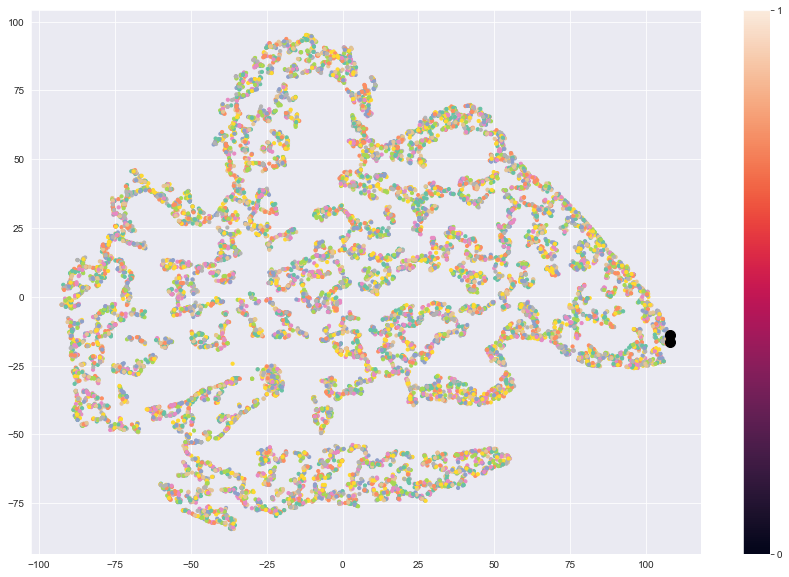

In [292]:
NN2cluster = np.argmax(np.abs(svd_transform ), axis=0)
import seaborn as sns
import matplotlib.cm as cm
cmap = cm.tab20
cmap = cm.get_cmap('hsv', 20) 
cmap = cm.get_cmap('jet', 20)
#cmap = cm.tab20

colors = sns.color_palette("Set2", n_colors=len(tsne_transform))

plt.figure(figsize=(15,10))
plt.scatter(tsne_transform [:,0],tsne_transform [:,1],c=colors, cmap=cmap, s=10)
plt.scatter(tsne_transform [NN2cluster[:],0],tsne_transform [NN2cluster[:],1], c='black', s=100)
#plt.scatter(tsne_mat[NN2cluster2[:],0],tsne_mat[NN2cluster2[:],1], c='red', s=100)
plt.colorbar(ticks=range(20))

In [293]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# chargement des données
df = df_avis_un

# extraction des colonnes d'intérêt
df_good = df[df['note'] >= 8] # on filtre les notes >= 8
X = df_good.pivot(index='title', columns='author', values='note').fillna(0)

# normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# définition du nombre de clusters
kmeans = KMeans(n_clusters=3)

# exécution de l'algorithme de clustering
kmeans.fit(X_scaled)

# ajout des labels de cluster aux titres
X['cluster'] = kmeans.labels_

# affichage des résultats
print(X)

plt.scatter(X['author'], X['note'], c=X['cluster'])
plt.xlabel('Utilisateurs')
plt.ylabel('Notes')
plt.show()



/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


author              --- JD ---  BDPHILOU  Belboudin  Biff  Brissac  Chabousse  \
title                                                                           
&cetera                    0.0       0.0        0.0   0.0      0.0        0.0   
011                        0.0       0.0        0.0   0.0      0.0        0.0   
1, 2 Truie !               0.0       0.0        0.0   0.0      0.0        0.0   
10' to kill                0.0       0.0        0.0   0.0      0.0        0.0   
1001 Karawane              0.0       0.0        0.0   0.0      0.0        0.0   
...                        ...       ...        ...   ...      ...        ...   
Échecs                     0.0       8.0        0.0  10.0      0.0        0.0   
Émoticon                   0.0       0.0        0.0   0.0      0.0        0.0   
Équibil                    0.0       0.0        0.0   0.0      0.0        0.0   
Équilibre instable         0.0       0.0        0.0   0.0      0.0        0.0   
ごきぶりポーカー                   0

KeyError: 'author'